In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import astropy.units as u
import astropy.constants as const
import pandas as pd
from scipy.integrate import quad_vec, cumulative_trapezoid
from scipy.special import spherical_jn
from collections.abc import Iterable
from aidm.const import *
import aidm.experiments as x
from astropy.table import Table
from aidm.cross_sections import cs_limit
from aidm.dm_velocity import vdm
from aidm.rate import rate

## set fig params|
sns.set_context("paper")
sns.set_style('ticks')
sns.set_palette('colorblind')
figparams = {
        'text.latex.preamble': [r'\usepackage{amsmath}', r'\boldmath'],
        'text.usetex':True,
        'axes.labelsize':20.,
        'xtick.labelsize':16,
        'ytick.labelsize':16,
        'figure.figsize':[10., 8.],
        'font.family':'DejaVu Sans',
        'legend.fontsize':18}
plt.rcParams.update(figparams)
cs = plt.rcParams['axes.prop_cycle'].by_key()['color']
import matplotlib
matplotlib.use('Agg')
%matplotlib inline


u.set_enabled_equivalencies(u.mass_energy())

/usr/local/Cellar/python@3.9/3.9.2_4/Frameworks/Python.framework/Versions/3.9/lib/python3.9/_collections_abc.py:940: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


In [2]:
RECALC_LIMITS = False

In [3]:
exps = ['GDM', 'MAQRO', 'Pino', None, 'BECCAL']

In [4]:
data_dir = '../data/'

## load 5th force constraints + define conversion to sigma_n
ffmphi, ffyn = np.loadtxt(data_dir+'AllynVSmPhiGeV.dat', unpack=True)
ffmphi = (ffmphi*u.GeV).to(u.MeV)


def yn_to_sigman(yn, mx, mphi, yx=np.sqrt(4*np.pi), mux=None, vdm=vdm):
    if mux == None:
        mux = mx
    massfac = mux**2/(mphi**2+vdm**2*mx**2)**2
    sig_in_invGeV = (yn**2 * yx**2 * massfac * 1. / (4 * np.pi)).to(1./u.GeV**2)
    return (sig_in_invGeV*1./lp**2).to(u.cm**(2))


## load other constraints
HeNRdat = pd.read_csv(data_dir+'NR.txt', names=['mx', 'sigma'], delimiter='\s+').sort_values(by='mx')
Hephodat = pd.read_csv(data_dir+'phonon2.txt', names=['mx', 'sigma'], delimiter='\s+').sort_values(by='mx')


## self-interaction constraints
def sigma_self(mx, mphi, gstar=10):
    return (1.55e-24*u.cm**2*(mphi/mx)**4*(gstar/10)**(0.5)*(u.GeV/mx)).to(u.cm**2)

In [5]:
def plot_diagram_subplot():
    qdeltax = np.logspace(-2,2,2000)
    f,ax = plt.subplots(1,1,figsize=(10,6))
    plt.plot(np.log10(qdeltax), 1-np.sin(qdeltax)/qdeltax, lw=4)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(4)
    ax.tick_params(width=4)
    ax.tick_params(axis='both', which='major', labelsize=25)

    plt.xlabel(r'$\log_{10} q\Delta x$', fontsize=30)
    plt.ylabel(r'$\rm{Decoherence~Effect}$', fontsize=30)
    plt.savefig('../results/diagram_subplot.pdf', dpi=300, bbox_inches="tight")

In [25]:
def plot_exp(ax, exp, qmin=True, mphi_ratios=1.e-5, medtype='light', phase=False):
    if RECALC_LIMITS:
        get_lim(exp, qmin=qmin, mphi_ratios=mphi_ratios, medtype=medtype)
    ## load data
    try:
        fn = f'../results/limits/{exp}_{qmin}_{medtype[0]}'
        if phase:
            fn += "_phase.dat"
        else:
            fn += ".dat"
        dat = Table.read(fn, format='ascii.ecsv')
        if medtype=='light':
            dat[f'sigma_{int(-1.*np.log10(mphi_ratios))}']
        else:
            dat[f'sigma']
    except KeyError:
        print("Can't find column. Looking for single mphi version.")
        fn = f'../results/limits/{exp}_{qmin}_{medtype[0]}_{int(-1.*np.log10(mphi_ratios))}.dat'
        dat = Table.read(fn, format='ascii.ecsv')
    except (IOSError, OSError):
        print("Can't find file. Re-running limits.")
        get_lim(exp, qmin=qmin, mphi_ratios=mphi_ratios, medtype=medtype)
        fn = f'../results/limits/{exp}_{qmin}_{medtype[0]}_{int(-1.*np.log10(mphi_ratios))}.dat'
        dat = Table.read(fn, format='ascii.ecsv')

    ls = 'solid'
    label = f'$\\rm{{{exp}}}$'
        
    if medtype=='heavy':
        alpha = 0.3
        label = None
        ax.loglog(dat['mx'], dat[f'sigma'], lw=2, 
                  c=cs[exps.index(exp)], ls=ls, label=label, alpha = alpha)
    else:
        alpha = 1.0
        ax.loglog(dat['mx'], dat[f'sigma_{int(-1.*np.log10(mphi_ratios))}'], lw=2, 
                  c=cs[exps.index(exp)], ls=ls, label=label, alpha = alpha)

In [26]:
def plot_specific_mphi(mpr, plot_noqmin=True):
    f, ax = plt.subplots(1,1, figsize=(10,6))

    for ex in exps:
        if ex == None:
            continue
        plot_exp(ax, ex)
        if plot_noqmin:
            plot_exp(ax, ex, qmin=False)
    ## text indicating mediator mass
    plt.text(0.15, 0.05,f'$m_{{\phi}} = 10^{{{int(np.log10(mpr))}}}m_{{\chi}}$',
             horizontalalignment='center', verticalalignment='center', 
             transform = ax.transAxes,fontsize=16)

    ## plot other limits
    ## self-interaction
    plt.loglog(ffmphi*1./mpr, sigma_self(ffmphi*1./mpr, ffmphi), color='k')
    plt.fill_between(ffmphi*1./mpr, sigma_self(ffmphi*1./mpr, ffmphi), 1, color='k', alpha=0.3, hatch='X')
    ffsigma = yn_to_sigman(ffyn, ffmphi*1./mpr, ffmphi)
    plt.loglog(ffmphi*1./mpr, ffsigma, color='k')
    plt.fill_between(ffmphi*1./mpr, ffsigma, 1., color='k', alpha=0.3)

    plt.loglog(10**HeNRdat['mx'], 10**HeNRdat['sigma'], color='black', alpha=0.5)
    plt.text(3, 1.e-43, 'He NR', color='gray', rotation=-20)
    plt.loglog(10**Hephodat['mx'], 10**Hephodat['sigma'], color='black', alpha=0.5, ls='dashed')
    plt.text(1.e-1, 9.e-44, 'He 2-phonon', color='gray', rotation=-42)

    plt.legend(loc='upper left', fontsize=15)
    plt.xlabel(r'$m_{\chi}~[\rm{MeV}]$');
    plt.ylabel(r'$\bar{\sigma}_n~[\rm{cm}^2]$');
    plt.xlim([1.e-9, 1.e3])
    plt.ylim([1.e-45, 1.e-20])

    plt.savefig(f'../results/reach_plot_{int(-1.*np.log10(mpr))}.pdf')

In [27]:
def plot_panel(ax, mpr, qmin=False, asym=False, legend=False, phase=False):
    for ex in exps:
        if ex == None:
            continue
        plot_exp(ax, ex, qmin=qmin, mphi_ratios=mpr, phase=phase)
    ## add text
    ax.text(0.15, 0.95,f'$m_{{\phi}} = 10^{{{int(np.log10(mpr))}}}m_{{\chi}}$',
             horizontalalignment='center', verticalalignment='center', 
             transform = ax.transAxes,fontsize=16)
    ax.text(0.85, 0.95,r'$\Omega_\chi = 0.05\ \Omega_{\rm{DM}}$',
             horizontalalignment='center', verticalalignment='center', 
             transform = ax.transAxes,fontsize=16)
    ax.text(0.85, 0.83,r'$y_{{\chi}} = \sqrt{4\pi}$',
             horizontalalignment='center', verticalalignment='center', 
             transform = ax.transAxes,fontsize=16)
    if phase:
        ax.text(0.85, 0.05,r'$\rm{Phase}$',
                 horizontalalignment='center', verticalalignment='center', 
                 transform = ax.transAxes,fontsize=16)
    else:
        ax.text(0.85, 0.05,r'$\rm{Decoherence}$',
                 horizontalalignment='center', verticalalignment='center', 
                 transform = ax.transAxes,fontsize=16)
    
    ## text indicating asymmetric dm
    if asym:
        ax.text(0.84, 0.89, r'$\rm{Asymmetric~DM}$', 
                horizontalalignment='center', verticalalignment='center',
                transform = ax.transAxes,fontsize=16)

    ## plot other limits
    ## self-interaction
    if not asym:
        mphit = ffmphi[ffmphi<1.*u.MeV*mpr]
        ax.loglog(mphit*1./mpr, sigma_self(mphit*1./mpr, mphit), color='k')
        ax.fill_between(mphit*1./mpr, sigma_self(mphit*1./mpr, mphit), 1, facecolor='grey', 
                        alpha=0.5, hatch='X', edgecolor='k')
#         ax.fill_between(ffmphi*1./mpr, sigma_self(ffmphi*1./mpr, ffmphi), 1, facecolor=None,
#                         hatch='X', edgecolor='k')
    ffsigma = yn_to_sigman(ffyn, ffmphi*1./mpr, ffmphi)
    ax.loglog(ffmphi*1./mpr, ffsigma, color='k')
    ax.fill_between(ffmphi*1./mpr, ffsigma, 1., color='k', alpha=0.3)

    ax.loglog(10**HeNRdat['mx'], 10**HeNRdat['sigma'], color='black', alpha=0.5)
    ax.text(3, 1.e-43, 'He NR', color='gray', rotation=-20)
    ax.loglog(10**Hephodat['mx'], 10**Hephodat['sigma'], color='black', alpha=0.5, ls='dashed')
    ax.text(1.e-1, 9.e-44, 'He 2-phonon', color='gray', rotation=-42)
    

    if legend:
        ax.legend(loc='lower left', fontsize=15)
    ax.set_xlabel(r'$m_{\chi}~[\rm{MeV}]$');
    ax.set_ylabel(r'$\bar{\sigma}_n~[\rm{cm}^2]$');
    ax.set_xlim([1.e-6, 1.e3])
    ax.set_ylim([1.e-47, 1.e-25])

In [28]:
def plot_four_panel(rat1, rat2, rat3, rat4):
    f, ax = plt.subplots(4,2, figsize=(15,20))
    plot_panel(ax[0,0], rat1, qmin=False, asym=True, phase=False)
    plot_panel(ax[0,1], rat1, qmin=True, phase=True, asym=True)
    plot_panel(ax[1,0], rat2, asym=True)
    plot_panel(ax[1,1], rat2, qmin=True, phase=True, asym=True)
    plot_panel(ax[2,0], rat3, asym=True)
    plot_panel(ax[2,1], rat3, qmin=True, phase=True, asym=True)
    plot_panel(ax[3,0], rat4, asym=True)
    plot_panel(ax[3,1], rat4, qmin=True, phase=True, asym=True, legend=True)
    f.tight_layout()
    plt.savefig(f'../results/reach_plot.pdf')

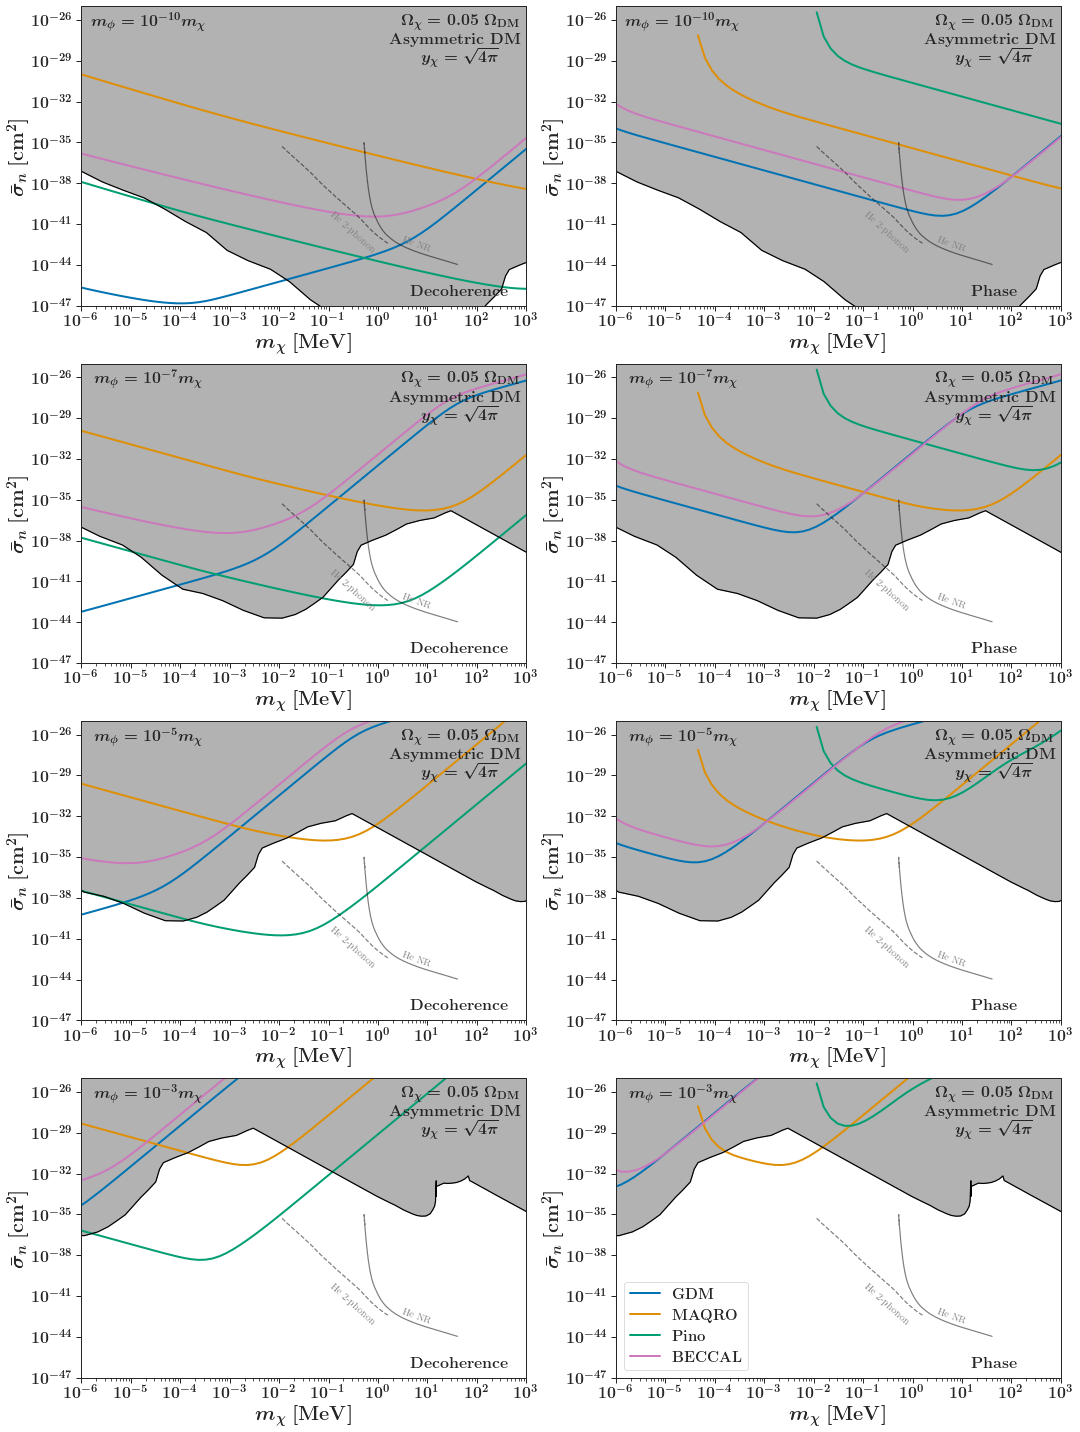

In [29]:
plot_four_panel(1.e-10, 1.e-7, 1.e-5, 1.e-3)

In [12]:
def plot_qmin_noqmin(mpr=1.e-3):
    f, ax = plt.subplots(1,1, figsize=(10,6))

    for ex in exps:
        if ex == None:
            continue
        plot_exp(ax, ex)
        plot_exp(ax, ex, qmin=False)
        plot_exp(ax, ex, medtype='heavy')
#         plot_exp(ax, ex, qmin=False, medtype='heavy')
    ## text indicating mediator mass
    plt.text(0.15, 0.05,f'$m_{{\phi}} = 10^{{{int(np.log10(mpr))}}}m_{{\chi}}$',
             horizontalalignment='center', verticalalignment='center', 
             transform = ax.transAxes,fontsize=16)

    plt.loglog(100,100, ls='dashed', color='k', label=r'$q_{\rm{min}} = 0$')
    plt.loglog(100,100, ls='solid', color='k', alpha=0.3, label=r'$\rm{heavy~mediator}$')
    plt.legend(loc='lower right', fontsize=15, ncol=2)
    plt.xlabel(r'$m_{\chi}~[\rm{MeV}]$');
    plt.ylabel(r'$\bar{\sigma}_n~[\rm{cm}^2]$');
    plt.xlim([1.e-9, 1.e3])
    plt.ylim([1.e-45, 1.e-20])

    plt.savefig(f'../results/qmin_comp.pdf')

In [13]:
def cs_to_alpham(cs, mphis, alphadm=1, mxx=1.*u.MeV, vdm=vdm):
    ## convert cs to MeV
    csm = (cs*lp**2).to(u.MeV**(-2))
    ydm = np.sqrt(4*np.pi*alphadm)
#     mu = mxx*mphis/(mxx+mphis)
    mu = mxx
    yx2 = csm*4*np.pi/ydm**2*(mxx**2*vdm**2+mphis**2)**2/mu**2
    alpham = yx2/(4.*np.pi)
    return alpham

In [14]:
def plot_riedel_comp(mxx=1.*u.MeV, mphis=np.logspace(-8, -3, 10)*u.MeV):
    to_comp = ['MAQRO', 'Pino']
    f, ax = plt.subplots(1,1, figsize=(10,6))
    for ex in to_comp:
        class_ = getattr(x,ex)
        exp = class_()
        lims = cs_limit(mxx, ex=exp, medtype='light', mphi=mphis)
        alpham = cs_to_alpham(lims, mphis)
        print(f'Done getting limit for {ex} with qmin')
        plt.loglog(mphis*1.e6, alpham, lw=2, c=cs[exps.index(ex)], label=f'$\\rm{{{ex}}}$')
        plt.fill_between(mphis*1.e6, alpham, 1., color=cs[exps.index(ex)], alpha=0.3)
        
        exp.qmin = 1.e-20*u.MeV
        lims = cs_limit(mxx, ex=exp, medtype='light', mphi=mphis)
        alpham = cs_to_alpham(lims, mphis)
        print(f'Done getting limit for {ex} without qmin')
        plt.loglog(mphis*1.e6, alpham, lw=2, c=cs[exps.index(ex)], ls='dashed')
        print(f'Min limit: {np.min(alpham)}')
    plt.loglog(100,100, ls='dashed', color='k', lw=2, 
               label=r'$q_{\rm{min}} = 0~[\rm{Riedel~\&~Yavin}~(2017)]$')
#     plt.loglog(ffmphi, ffyn**2/(np.pi*4), color='k', lw=2)
#     plt.fill_between(ffmphi, ffyn**2/(np.pi*4), 1.,color='k', alpha=0.3)
    plt.text(0.13, 0.93,r'$m_{{\chi}} = 1~\rm{MeV}$',
             horizontalalignment='center', verticalalignment='center', 
             transform = ax.transAxes,fontsize=16)
    plt.xlabel(r'$m_\phi~[\rm{eV}]$')
    plt.ylabel(r'$\alpha_n$')
    plt.legend(loc='lower right', fontsize=15)
    plt.xlim([1.e-2, 1.e3])
    plt.ylim([1.e-36, 1.e-17])
    plt.savefig('../results/riedel_comp.pdf')

In [15]:
def plot_decoh():
    f, ax = plt.subplots(1,1, figsize=(10,6))
    mxs = np.logspace(-6,3,10)*u.MeV
    for ex in exps:
        if ex == None:
            continue
        class_ = getattr(x,ex)
        exp = class_()
        s = rate(mxs, ex=exp, medtype='light', mphi=mxs*1.e-3)
        print(f'Done getting limit for {ex} with qmin')
        plt.loglog(mxs, s, lw=2, c=cs[exps.index(ex)], label=f'$\\rm{{{ex}}}$')
#     plt.loglog(ffmphi, ffyn**2/(np.pi*4), color='k', lw=2)
#     plt.fill_between(ffmphi, ffyn**2/(np.pi*4), 1.,color='k', alpha=0.3)
#     plt.text(0.13, 0.93,r'$m_{{\chi}} = 1~\rm{MeV}$',
#              horizontalalignment='center', verticalalignment='center', 
#              transform = ax.transAxes,fontsize=16)
    plt.text(0.87, 0.93,r'$\bar{\sigma}_n = 1~\rm{cm}^2/\rm{g}$',
             horizontalalignment='center', verticalalignment='center', 
             transform = ax.transAxes,fontsize=16)
    plt.xlabel(r'$m_\chi~[\rm{MeV}]$')
    plt.ylabel(r'$s$')
    plt.legend(loc='lower right', fontsize=15)
#     plt.xlim([1.e-2, 1.e3])
#     plt.ylim([1.e-36, 1.e-17])
    plt.savefig('../results/decoh.pdf')

Done getting limit for GDM with qmin
Done getting limit for MAQRO with qmin
Done getting limit for Pino with qmin
Done getting limit for BECCAL with qmin


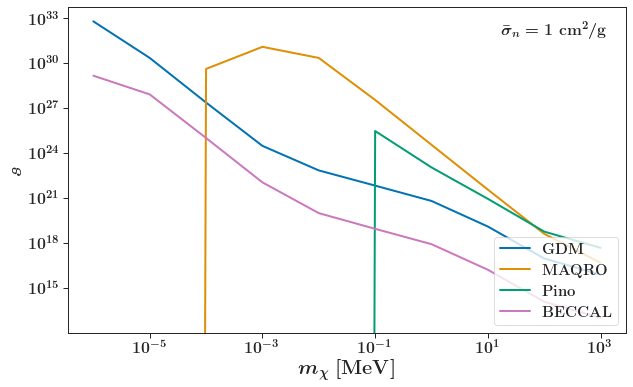

In [21]:
plot_decoh()

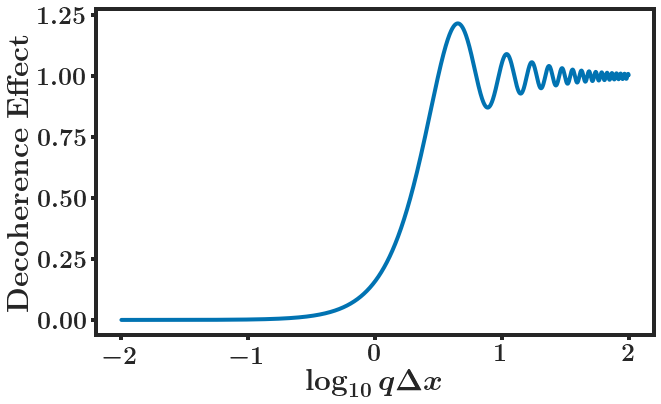

In [60]:
plot_diagram_subplot()

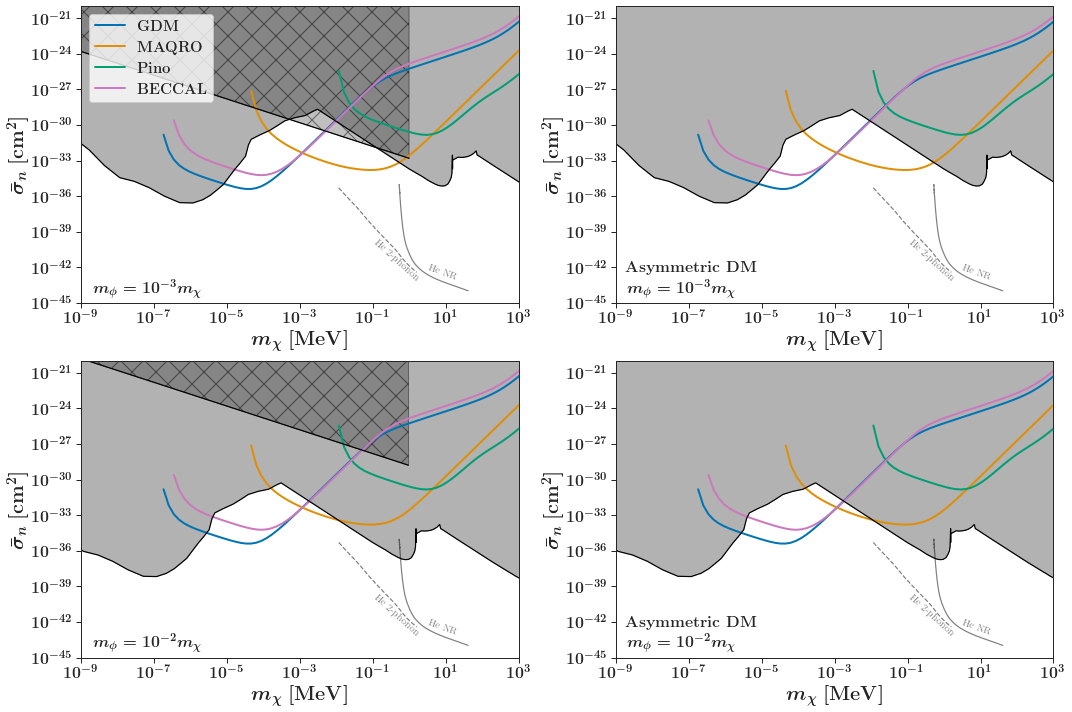

In [76]:
plot_four_panel(1.e-3, 1.e-2)

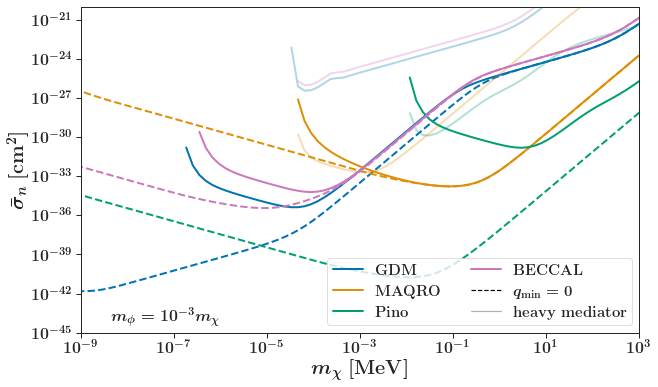

In [115]:
plot_qmin_noqmin()

Done getting limit for MAQRO with qmin
Done getting limit for MAQRO without qmin
Min limit: 1.4741480668448951e-28
Done getting limit for Pino with qmin
Done getting limit for Pino without qmin
Min limit: 3.431769411430833e-36


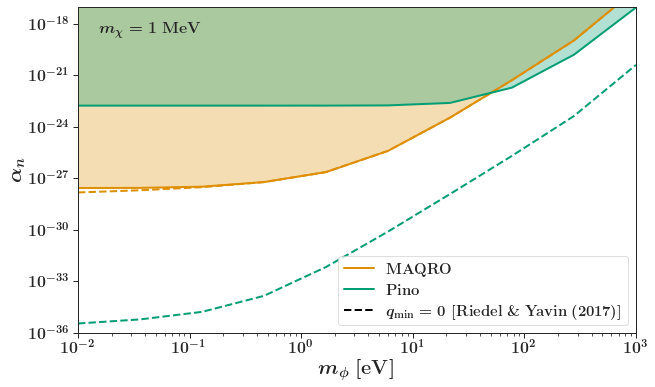

In [113]:
plot_riedel_comp()

In [89]:
print(exps)
def mx_est(N, deltax):
#     return np.sqrt(N)/deltax
    return 1./(np.sqrt(N)*deltax)
def get_all():
    for ex in exps:
        if ex==None:
            continue
        class_ = getattr(x, ex)
        exp = class_()
        print(mx_est(exp.N, exp.deltax))

['GDM', 'MAQRO', 'Pino', None, 'BECCAL']


In [90]:
get_all()

8.448246774521824e-20 MeV
1.97e-11 MeV
1.4482945214501815e-13 MeV
7.040205645434854e-15 MeV


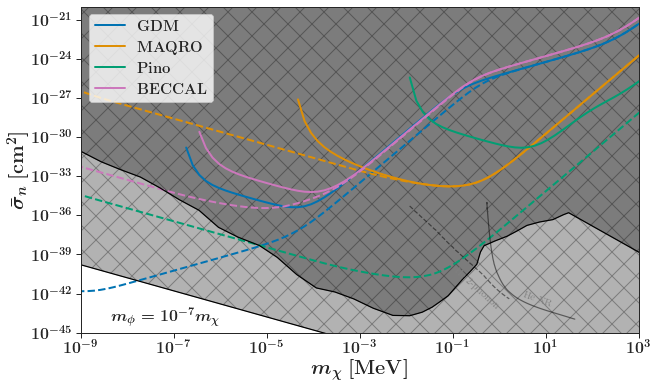

In [88]:
plot_specific_mphi(1.e-7)